In [3]:
import numpy as np
import imageio.v2 as imageio
import scipy.ndimage
import math
import sklearn.neighbors
from os import listdir

In [4]:
def luminance(l):
    if len(l.shape) > 2:
        l = 0.2126 * l[:, :, 0] + 0.7152 * l[:, :, 1] + 0.0722 * l[:, :, 2]
        l = l.astype(np.uint8)
    return l

In [5]:
def load_images(filenames):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    return images

In [6]:
filename_images_0 = "Dataset/0/0.png Dataset/0/1.png Dataset/0/2.png Dataset/0/3.png Dataset/0/4.png Dataset/0/5.png Dataset/0/6.png Dataset/0/7.png Dataset/0/8.png Dataset/0/9.png".rstrip().split(" ")
filename_images_1 = "Dataset/1/0.png Dataset/1/1.png Dataset/1/2.png Dataset/1/3.png Dataset/1/4.png Dataset/1/5.png Dataset/1/6.png Dataset/1/7.png Dataset/1/8.png Dataset/1/9.png".rstrip().split(" ")
filename_test_images = "Dataset/0/0.png Dataset/0/1.png Dataset/0/2.png Dataset/0/3.png Dataset/0/4.png Dataset/0/5.png Dataset/0/6.png Dataset/0/7.png Dataset/0/8.png Dataset/0/9.png".rstrip().split(" ")

images0 = load_images(filename_images_0)
images1 = load_images(filename_images_1)
test_images = load_images(filename_test_images)

In [7]:
import scipy.signal

def gradient_descriptors(img):
    img = luminance(img)
    
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    gx = scipy.signal.convolve2d(img, sobel_x)
    gy = scipy.signal.convolve2d(img, sobel_y)

    mag = np.sqrt(gx**2 + gy**2)
    mag = mag/mag.sum()

    angle = np.arctan((gy+0.0000001)/gx)
    angle[gx == 0] = np.pi/2
    angle += np.pi

    # angle_digitized = np.digitize(angle.reshape((-1)), bins=12)
    hog = np.zeros((12,))

    for a, m in zip(angle.reshape((-1)), mag.reshape((-1))):
        for idx, possible_bin in enumerate(np.arange(0, np.pi*2, np.pi*2 / 12)):
            if a > possible_bin and a < possible_bin + (np.pi*2 / 12):
                hog[idx] += m
    # for idx, m in zip(angle_digitized, mag):
    #     if m != np.nan:
    #         hog[idx] += m

    return hog
        

In [8]:
hog = gradient_descriptors(images0[0])
hog

/var/folders/t5/925j6xzs3573mclrt4vbd1hw0000gp/T/ipykernel_33381/3927622633.py:15: RuntimeWarning: divide by zero encountered in divide
  angle = np.arctan((gy+0.0000001)/gx)


array([0.        , 0.        , 0.        , 0.20446263, 0.11475171,
       0.1382678 , 0.14334799, 0.1545845 , 0.24001486, 0.        ,
       0.        , 0.        ])

In [9]:
images0_feats = np.array(list(map(gradient_descriptors, images0)))
images1_feats = np.array(list(map(gradient_descriptors, images1)))
test_images_feats = np.array(list(map(gradient_descriptors, test_images)))

labels = np.concatenate([np.zeros((len(filename_images_0),), dtype=int), np.ones((len(filename_images_1),), dtype=int)], axis=0)
training_set = np.concatenate([images0_feats, images1_feats], axis=0)
knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)
knn.fit(training_set, labels)


/var/folders/t5/925j6xzs3573mclrt4vbd1hw0000gp/T/ipykernel_33381/3927622633.py:15: RuntimeWarning: divide by zero encountered in divide
  angle = np.arctan((gy+0.0000001)/gx)


KNeighborsRegressor(n_neighbors=3)

array([0.33333333, 0.        , 0.66666667, 0.33333333, 0.33333333,
       0.66666667, 0.        , 0.        , 0.66666667, 0.        ])

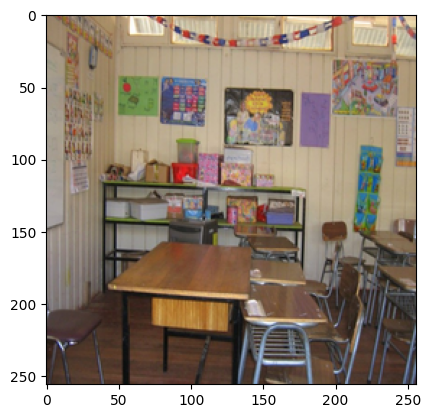

In [10]:
import matplotlib.pyplot as plt
plt.imshow(test_images[8])
knn.predict(test_images_feats)

In [18]:
import sklearn.feature_extraction.image

def get_patches(img_file, random_state, tam_patch=(11, 11), n_patches=250):
    img = imageio.imread(img_file)[..., :3]
    patch = sklearn.feature_extraction.image.extract_patches_2d(img, 
                               patch_size=tam_patch,
                               max_patches=n_patches, 
                               random_state=random_state)
    
    return patch.reshape((n_patches, -1))

Patches extracted to create dictionary of features
Total of images =  50
Size of each array of patches =  (250, 675)


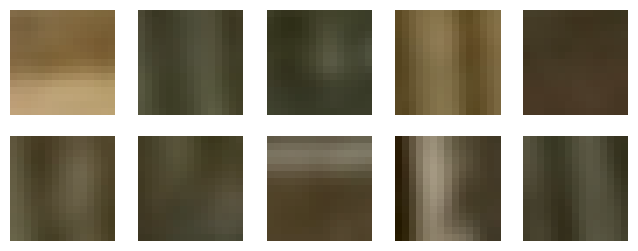

In [19]:
import joblib

# BOF parameters
tam_patch = (15, 15)
n_patches = 250
path_imgs = './Dataset/0/'
random_state = 1

# get list of files
l_imgs = listdir(path_imgs)
# total of images
n_imgs = len(l_imgs)

# Extract patches in parallel
# returns a list of the same size of the number of images
patch_arr = joblib.Parallel(n_jobs=-1)(joblib.delayed(get_patches)(path_imgs+arq_img,
                                                      random_state,
                                                      tam_patch,
                                                      n_patches)
                                for arq_img in l_imgs)

print('Patches extracted to create dictionary of features')
print('Total of images = ', len(patch_arr))
print('Size of each array of patches = ', patch_arr[0].shape)

# shows some image patches
img_ind = 32
plt.figure(figsize=(8,3))
for i in np.arange(1,11):
    plt.subplot(2,5,i)
    plt.imshow(patch_arr[img_ind][i].reshape((tam_patch[0],tam_patch[1],3)))
    plt.axis('off')

In [25]:
patch_arr = np.array(patch_arr, copy=True)
patch_arr = patch_arr.reshape((-1,
                               tam_patch[0], tam_patch[0], 3))

# obtaining features lbp for each patch
patch_feats = []
for pat in patch_arr:
    f = gradient_descriptors(pat)
    patch_feats.append(f)

patch_feats = np.array(patch_feats)
print('Instances = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])
print('Created LBP feature spaces')
print('\tpatches = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])

/var/folders/t5/925j6xzs3573mclrt4vbd1hw0000gp/T/ipykernel_33381/3927622633.py:15: RuntimeWarning: divide by zero encountered in divide
  angle = np.arctan((gy+0.0000001)/gx)


Instances =  12500  size =  12
Created LBP feature spaces
	patches =  12500  size =  12


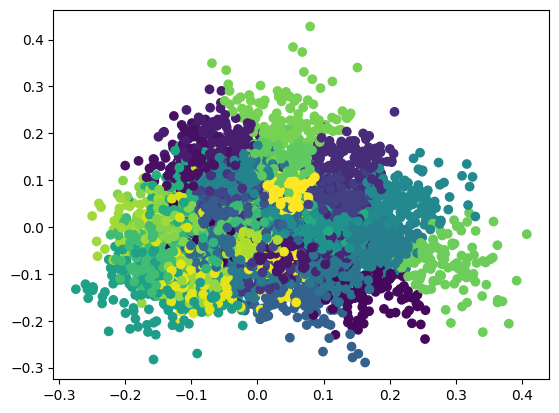

In [38]:
n_dic = 50  # size of the dictionary
random_state = 1

# Define a KMeans clustering model
kmeans_model = sklearn.cluster.KMeans(n_clusters=n_dic,
                      verbose=False,
                      init='random',
                      random_state=random_state,
                      n_init=3)

# fit the model
kmeans_model.fit(patch_feats)
pca = sklearn.decomposition.PCA(2)
pca_feat = pca.fit_transform(patch_feats)
plt.scatter(pca_feat[:, 0], pca_feat[:, 1], c=kmeans_model.labels_)

array([0.        , 0.        , 0.        , 0.17483307, 0.02544001,
       0.21372735, 0.26610504, 0.02624849, 0.21700413, 0.        ,
       0.        , 0.        ])